<a href="https://colab.research.google.com/github/mdoroch/SPBU_docs_classification_-2021-2022-/blob/main/AD_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [575]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
warnings.filterwarnings("ignore")

plt.style.context('fivethirtyeight')

In [576]:
data = pd.read_csv('digit.dat', sep=';')

In [577]:
data.head(5)

,A,B,C,D,E,F,G,H,A2,B2,C2,D2,E2,F2,G2,H2
0,seven,ONE,ZERO,ONE,ZERO,ZERO,ONE,ZERO,seven,ONE,ZERO,ONE,ZERO,ZERO,ONE,ZERO
1,one,ZERO,ZERO,ONE,ZERO,ZERO,ONE,ZERO,one,ZERO,ZERO,ONE,ZERO,ZERO,ONE,ZERO
2,four,ZERO,ONE,ONE,ONE,ZERO,ONE,ZERO,four,ZERO,ONE,ONE,ONE,ZERO,ONE,ZERO
3,two,ONE,ONE,ONE,ONE,ONE,ZERO,ZERO,two,ONE,ONE,ONE,ONE,ONE,ZERO,ZERO
4,eight,ZERO,ONE,ONE,ONE,ONE,ONE,ONE,eight,ZERO,ONE,ONE,ONE,ONE,ONE,ONE


In [578]:
pd.unique(data.values.ravel('K'))

array(['seven', 'one  ', 'four ', 'two  ', 'eight', 'five ', 'six  ',
       'zero ', 'nine ', 'three', 'ONE ', 'ZERO', 'one', 'four', 'two',
       'five', 'six', 'zero', 'nine', 'ONE'], dtype=object)

In [579]:
encod_dict = {'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 
              'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9}

In [580]:
data = data.applymap(lambda val: encod_dict[(val.lower()).strip()])

In [581]:
data['A'].value_counts()

8    58
9    55
3    55
5    54
4    52
6    50
7    48
1    43
2    43
0    42
Name: A, dtype: int64

In [582]:
target = data.iloc[:, 0]

In [583]:
data = data.iloc[:, 1:8]
data.head()

,B,C,D,E,F,G,H
0,1,0,1,0,0,1,0
1,0,0,1,0,0,1,0
2,0,1,1,1,0,1,0
3,1,1,1,1,1,0,0
4,0,1,1,1,1,1,1


In [584]:
data.describe()

,B,C,D,E,F,G,H
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.750000,0.598000,0.726000,0.726000,0.420000,0.832000,0.668000
std,0.433446,0.490793,0.446456,0.446456,0.494053,0.374241,0.471403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.750000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Попытки определить количества кластеров 

In [585]:
link = linkage(data, 'ward', 'euclidean')

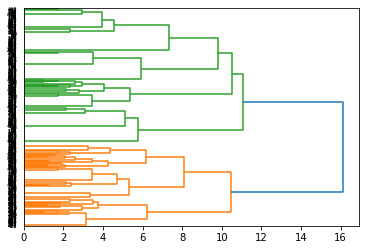

In [586]:
dn = dendrogram(link, orientation = "right")

По дендрограмме довольно сложно увидить большой скачок в расстояниях. Можно предположить, что он находится между 8 и 11 по оси абцисс, следовательно количество кластеров между 5 и 10. Попытаемся проанализировать по-другому

Построим график каменистой осыпи

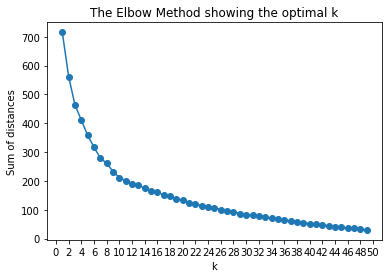

In [587]:
K = range(1, 50)
models = [KMeans(n_clusters=k, random_state=42).fit(data) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.xticks(np.arange(0, 52, step=2))
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Вывод: на графике каменистой осыпи видим излом в районе 10 кластеров, что полностью соответствует логике. Так как объекты в датасете представляют собой один символ, то и разумно ждать 10 кластеров, соответстующих цифрам от 0 до 9

In [588]:
# from sklearn.metrics import silhouette_score
# best_i = 0
# max = -1
# for i in range(2,50):
#   model = KMeans(n_clusters = i)
#   model.fit(data)
#   data['clusters'] = model.labels_
#   data.groupby('clusters').mean()
#   score = silhouette_score(data.drop(columns = ['clusters']), data['clusters'])
#   if score >= max:
#     best_i = i
#     max = score
# data.drop(columns = ['clusters'], inplace = True)
# best_i, max

In [589]:
data.head()

,B,C,D,E,F,G,H
0,1,0,1,0,0,1,0
1,0,0,1,0,0,1,0
2,0,1,1,1,0,1,0
3,1,1,1,1,1,0,0
4,0,1,1,1,1,1,1


вспомогательная функция, визуализирующая цифры на экране. Позвоняет интерпретировать результаты кластеризации.

Идея: подавать на вход фунции датафрейм, состоящий из средних значений по столбцам для кластеров. Среднее значение можно трактовать как частоту встречаемости конкретной черточки в кластере. Использовать это значение как "жирность" соответствующей черты

In [590]:
plot_dict = {'0':[[1,2],[3,3]],'1':[[1,1],[3,2]],'2':[[2,2],[3,2]],\
             '3':[[1,2],[2,2]], '4':[[1,1],[2,1]],'5':[[2,2],[2,1]],
             '6':[[1,2],[1,1]]}

def plot_digits(df):
  df = np.array(df)
  plot_shape = df.shape[0]
  plt.figure(figsize=(18, 10))
  k = 0
  for i in range(len(df)):
    for j in range(len(df[i])):
      plt.subplot(math.ceil(plot_shape/5), 5, k+1)

      plt.plot(plot_dict[str(j)][0], plot_dict[str(j)][1], alpha = df[i][j], color = 'blue')
    k+=1
  plt.show()

#Иерархическая кластеризация 

In [591]:
data['cluster'] = fcluster(link, 6, criterion = 'distance')
data.groupby('cluster').mean()

,B,C,D,E,F,G,H
cluster,,,,,,,
1,0.029412,0.852941,1.000000,1.000000,0.000000,0.852941,0.000000
2,0.000000,0.967742,0.548387,0.903226,0.548387,0.967742,0.806452
3,0.507246,0.188406,1.000000,0.000000,0.115942,0.913043,0.057971
4,0.785714,0.678571,0.000000,0.428571,0.428571,0.964286,0.214286
5,1.000000,0.531250,1.000000,0.812500,0.343750,1.000000,0.000000
6,1.000000,0.800000,0.000000,1.000000,0.475000,0.950000,1.000000
7,0.836066,0.344262,0.754098,0.983607,0.754098,0.000000,0.885246
8,1.000000,0.955224,1.000000,0.537313,1.000000,0.910448,1.000000
9,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000


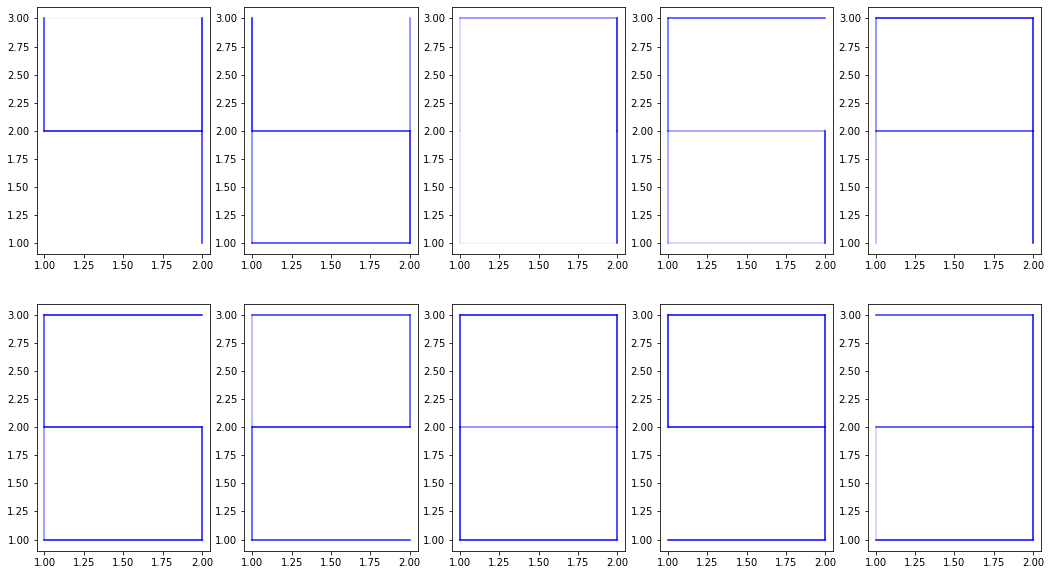

In [592]:
plot_digits(data.groupby('cluster').mean())

как можно видеть на таблице над графиком и на самом графике, кластера довольно сильно перемешаны. Например в кластере 5 только в половине случаев признак C = 1. Многие изображения на графиках вообще не вляются цифрами.

Можно сказать, что данный метод нам плохо подходит, так как результаты нас не удовлетворяют

In [593]:
data.drop(columns = ['cluster'], inplace = True)

#KMEANS

In [594]:
model = KMeans(n_clusters = 10)
model.fit(data)

KMeans(n_clusters=10)

In [595]:
data['clusters_kmeans'] = model.labels_
data.groupby('clusters_kmeans').mean()

,B,C,D,E,F,G,H
clusters_kmeans,,,,,,,
0,0.000000,0.000000,0.866667,0.155556,0.222222,0.888889,0.133333
1,0.947368,0.824561,1.000000,1.000000,1.000000,0.912281,0.894737
2,0.910448,0.000000,0.835821,0.940299,0.000000,0.880597,0.820896
3,0.192982,1.000000,0.982456,0.912281,0.052632,0.929825,0.157895
4,0.852459,0.918033,0.000000,0.885246,1.000000,0.852459,0.803279
5,0.877551,1.000000,0.000000,0.959184,0.000000,0.959184,0.918367
6,1.000000,1.000000,1.000000,0.940000,0.000000,0.900000,1.000000
7,0.820513,0.000000,0.846154,0.923077,1.000000,0.000000,0.897436
8,1.000000,0.157895,0.921053,0.000000,0.078947,0.921053,0.000000


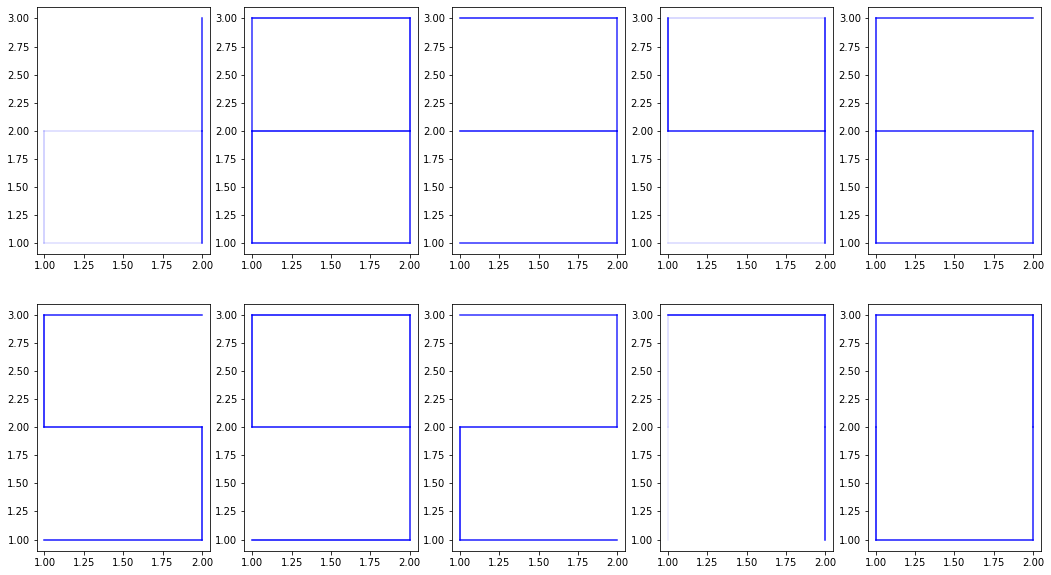

In [596]:
plot_digits(data.groupby('clusters_kmeans').mean())

In [597]:
data['clusters_kmeans'].value_counts()

2    67
4    61
3    57
1    57
6    50
5    49
0    45
7    39
8    38
9    37
Name: clusters_kmeans, dtype: int64

В данном случае ситуация оказалась лучше. На графиках четко видны цифры.

Можно сделать вывод, что мы получили хорошую кластеризацию с помощью этого алгоритма

#DBSCAN

In [598]:
data = data.drop(columns = ['clusters_kmeans'])

In [599]:
model = DBSCAN(eps = 0.5, min_samples=12)
model.fit(data)

DBSCAN(min_samples=12)

In [600]:
data['clusters_dbscan'] = model.labels_

In [601]:
data['clusters_dbscan'].value_counts()

-1    210
 5     42
 6     36
 3     35
 9     31
 7     29
 2     26
 8     25
 0     24
 4     24
 1     18
Name: clusters_dbscan, dtype: int64

In [602]:
data.groupby('clusters_dbscan').mean()

,B,C,D,E,F,G,H
clusters_dbscan,,,,,,,
-1,0.614286,0.504762,0.652381,0.666667,0.457143,0.714286,0.533333
0,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
1,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
2,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
3,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
4,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
5,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000


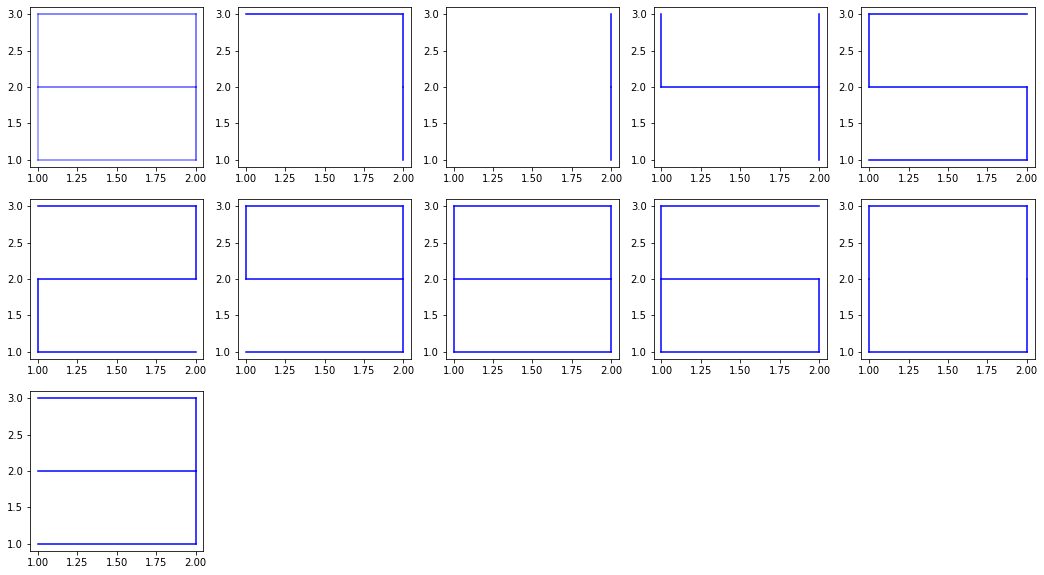

In [603]:
plot_digits(data.groupby('clusters_dbscan').mean())

мы получаем точные изображения цирф, но 210 объектов алгоритм посчитал выбросами 

Поскольку в данной задаче нам, в принципе, известно количество кластеров, которое мы хотим получить, то, по моему мнению, лучше всего тут подойдет KMEANS, который дал лучшие результаты.